In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext blackcellmagic

## Set date range

In [3]:
# specify the date range we wish to plot
date_range = pd.date_range('01-01-2006', datetime.today().date())

## Load in data from the csv file and make sure it looks correct

In [4]:
# csv_url = "https://raw.githubusercontent.com/collective-action/tech/master/actions.csv"
# df = pd.read_csv(csv_url, index_col=0)
json_url = "https://raw.githubusercontent.com/collective-action/tech/master/actions.json"
df = pd.read_json(json_url)
df["date"] = pd.to_datetime(df["date"])  # cast date col to datetime64
df.head()

,actions,author,companies,date,description,employment_types,locations,sources,struggles,tags,workers
0,[protest],nataliyaned,[ibm],1979-09-01,"IBM workers formed an organization, IBM: Speak...",[white_collar_workers],[worldwide],[https://twitter.com/clancynewyork/status/1175...,[ethics],[international_solidarity],NaN
1,[open_letter],nataliyaned,[at&t],1986-09-16,Fourteen employees at AT&T sign a letter warni...,[white_collar_workers],[usa],[https://www.nytimes.com/1986/09/16/science/so...,[ethics],None,14.0
2,[open_letter],nataliyaned,None,1986-09-16,"A group of computer professionals, led by Comp...",[white_collar_workers],[usa],[https://www.nytimes.com/1986/09/16/science/so...,[ethics],None,30.0
3,[open_letter],nataliyaned,None,1994-01-24,Computer Professionals for Social Responsibili...,[white_collar_workers],[online],[https://www.nytimes.com/1994/06/12/magazine/b...,[ethics],None,50000.0
4,[legal_action],organizejs,[microsoft],1998-11-23,A law firm representing 10 current and former ...,[contract_workers],[usa],[http://www.cnn.com/tech/computing/9811/23/mst...,"[unfair_labor_practices, pay_and_benefits]",None,10.0


In [6]:
len(df)

252

## Clean up string

In [45]:
df["struggles"] = df["struggles"].astype(str).str.strip("[]\'\'")
df["actions"] = df["actions"].astype(str).str.strip("[]\'\'")
df["companies"] = df["companies"].astype(str).str.strip("[]\'\'")
df["employment_types"] = df["employment_types"].astype(str).str.strip("[]\'\'")
df["sources"] = df["sources"].astype(str).str.strip("[]\'\'")
df["tags"] = df["tags"].astype(str).str.strip("[]\'\'")
df["locations"] = df["locations"].astype(str).str.strip("[]\'\'")

## One-hot encode "struggles", "employment_types", "actions", "companies"


In [46]:
def ohe(field):
    return (
        df[field].str.replace(" ", "").str.get_dummies(sep=",").add_prefix(f"{field}_")
    )

In [47]:
ohe_df = (
    df.join(ohe("struggles"))
    .join(ohe("actions"))
    .join(ohe("companies"))
    .join(ohe("employment_types"))
    .drop(["struggles", "actions", "companies", "employment_types"], axis=1)
)

In [48]:
ohe_df.head()

,author,date,description,locations,sources,tags,workers,struggles_'discrimination,struggles_'ethics,struggles_'job_security,...,employment_types_blue_collar_workers',employment_types_contract_workers,employment_types_contract_workers',employment_types_gig_workers,employment_types_gig_workers',employment_types_in_house_workers,employment_types_in_house_workers',employment_types_na,employment_types_white_collar_workers,employment_types_white_collar_workers'
0,nataliyaned,1979-09-01,"IBM workers formed an organization, IBM: Speak...",worldwide,https://twitter.com/clancynewyork/status/11758...,international_solidarity,NaN,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,nataliyaned,1986-09-16,Fourteen employees at AT&T sign a letter warni...,usa,https://www.nytimes.com/1986/09/16/science/sof...,None,14.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,nataliyaned,1986-09-16,"A group of computer professionals, led by Comp...",usa,https://www.nytimes.com/1986/09/16/science/sof...,None,30.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,nataliyaned,1994-01-24,Computer Professionals for Social Responsibili...,online,https://www.nytimes.com/1994/06/12/magazine/ba...,None,50000.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,organizejs,1998-11-23,A law firm representing 10 current and former ...,usa,http://www.cnn.com/tech/computing/9811/23/mste...,None,10.0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


## Defining worker priviledge vs precarity

In [49]:
ohe_df["is_priviledged"] = [
    True if x > 0 else False
    for x in ohe_df[
        ["employment_types_white_collar_workers"]
    ].sum(axis=1)
]

## Visualize total actions per month over past 3 years

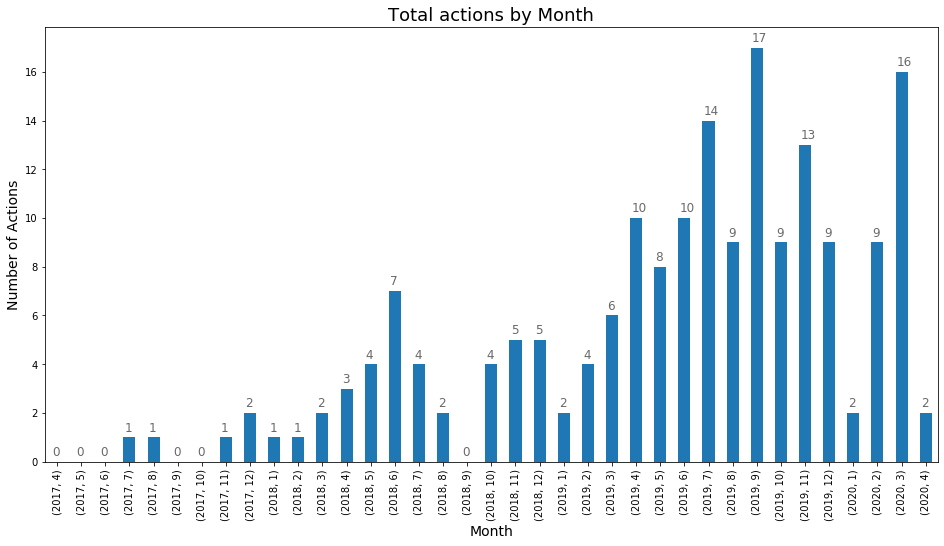

In [50]:
# fill dataframe with zeros for dates where no actions happened
sparse_df = df.loc[:, "date"].value_counts()

# set date range for month graph
today = datetime.today().date()
three_yrs_ago = f"{today.month}-{today.day}-{today.year-3}"
date_range_month = pd.date_range(three_yrs_ago, datetime.today().date())

# fill dataframe with zeros for dates where no actions happened
sparse_df = (
    df.loc[:, "date"]
    .value_counts()
    .reindex(date_range_month, fill_value=0)
    .to_frame(name="count")
)

# aggregate our dataframe by month
yearly_monthly_df = sparse_df.groupby([(sparse_df.index.year),(sparse_df.index.month)]).sum()

# plot the bar graph with annotation
ax = yearly_monthly_df.plot(kind="bar", figsize=(16, 8), legend=False)
ax.set_xlabel("Month", fontsize=14)
ax.set_ylabel("Number of Actions", fontsize=14)
ax.set_title("Total actions by Month", fontsize=18)
for i in ax.patches:
    ax.text(
        i.get_x() + 0.05,
        i.get_height() + 0.25,
        i.get_height(),
        fontsize=12,
        color="dimgrey",
    )

## Visualize total actions per year

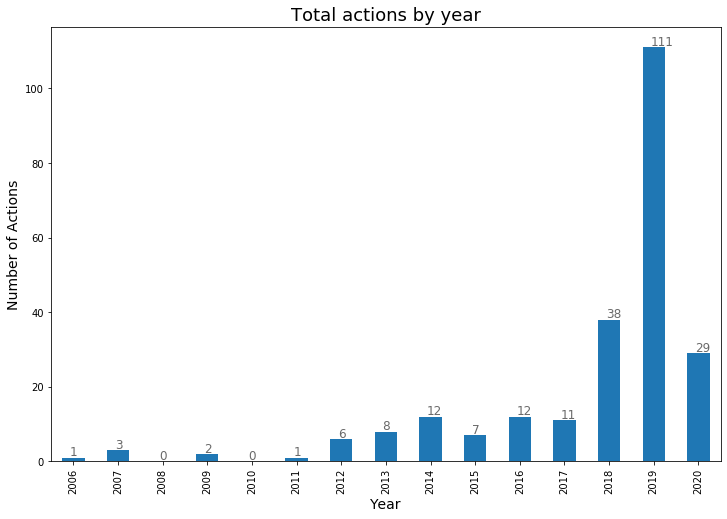

In [51]:
# fill dataframe with zeros for dates where no actions happened
sparse_df = df.loc[:, "date"].value_counts()

# fill dataframe with zeros for dates where no actions happened
sparse_df = (
    df.loc[:, "date"]
    .value_counts()
    .reindex(date_range, fill_value=0)
    .to_frame(name="count")
)

# aggregate our dataframe by year
yearly_df = sparse_df.groupby([sparse_df.index.year.rename("year")]).agg({"sum"})

# plot the bar graph with annotation
ax = yearly_df.plot(kind="bar", figsize=(12, 8), legend=False)
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Number of Actions", fontsize=14)
ax.set_title("Total actions by year", fontsize=18)
for i in ax.patches:
    ax.text(
        i.get_x() + 0.175,
        i.get_height() + 0.5,
        i.get_height(),
        fontsize=12,
        color="dimgrey",
    )

In [52]:
def get_yearly_count(cond):
    # fill dataframe with zeros for dates where no actions happened
    sparse_ohe_df = (
        ohe_df[ohe_df["is_priviledged"] == cond].loc[:, "date"].value_counts()
    )

    # fill dataframe with zeros for dates where no actions happened
    sparse_ohe_df = (
        ohe_df[ohe_df["is_priviledged"] == cond]
        .loc[:, "date"]
        .value_counts()
        .reindex(date_range, fill_value=0)
        .to_frame(name="count")
    )

    # aggregate our dataframe by year
    yearly_df = sparse_ohe_df.groupby([sparse_ohe_df.index.year.rename("year")]).agg(
        {"sum"}
    )
    yearly_df.columns = yearly_df.columns.get_level_values(0)
    return yearly_df

In [53]:
priviledged_vs_precarious_yearly_df = get_yearly_count(True).join(
    get_yearly_count(False),
    lsuffix="_of_priviledged_workers",
    rsuffix="_of_precarious_workers",
)

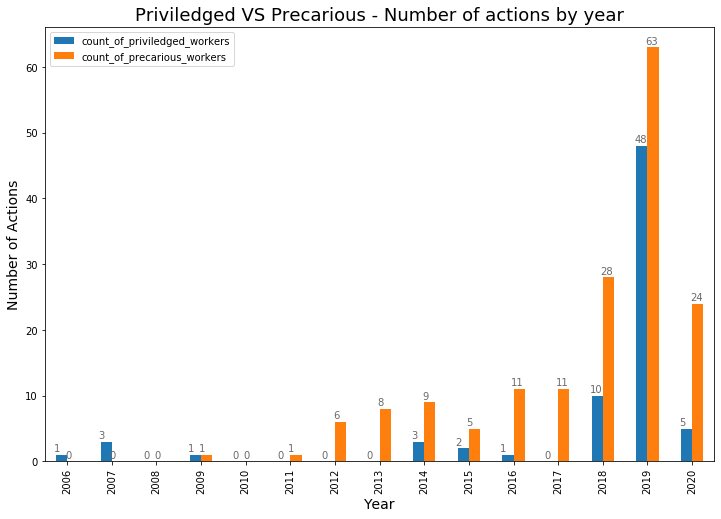

In [54]:
ax = priviledged_vs_precarious_yearly_df.plot(kind="bar", figsize=(12, 8))
ax.set_xlabel("Year", fontsize=14)
ax.set_ylabel("Number of Actions", fontsize=14)
ax.set_title("Priviledged VS Precarious - Number of actions by year", fontsize=18)
for i in ax.patches:
    ax.text(
        i.get_x() - 0.05,
        i.get_height() + 0.5,
        i.get_height(),
        fontsize=10,
        color="dimgrey",
    )

## Visualize total distribution of struggle

In [55]:
def get_struggles(cond):
    return ohe_df[ohe_df["is_priviledged"] == cond].filter(regex=("struggles_*")).sum()


struggles = pd.DataFrame(get_struggles(True)).join(
    pd.DataFrame(get_struggles(False)),
    lsuffix="_priviledged_workers",
    rsuffix="_precarious_workers",
)

Text(0.5, 1.0, 'Actions by kind of struggle')

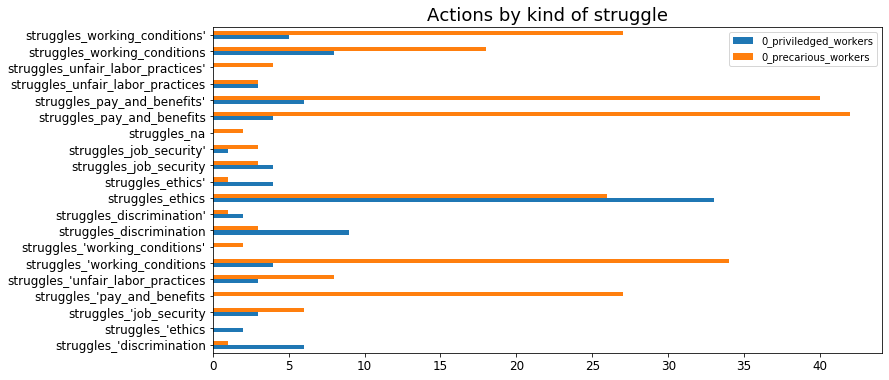

In [56]:
ax = struggles.plot(kind="barh", fontsize=12, figsize=(12, 6))
ax.set_ylabel(None)
ax.set_title("Actions by kind of struggle", fontsize=18)

## Visualize distribution of struggles over the years

In [57]:
def get_actions(cond):
    return ohe_df[ohe_df["is_priviledged"] == cond].filter(regex=("actions_*")).sum()


actions = pd.DataFrame(get_actions(True)).join(
    pd.DataFrame(get_actions(False)),
    lsuffix="_priviledged_workers",
    rsuffix="_precarious_workers",
)

Text(0.5, 1.0, 'Actions by kind of struggle')

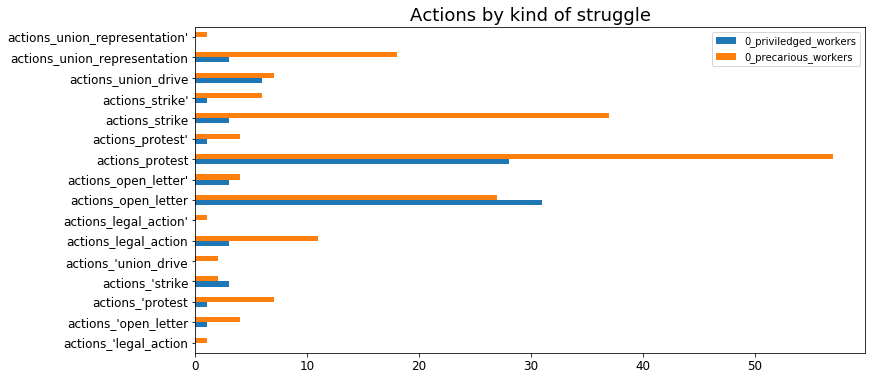

In [58]:
ax = actions.plot(kind="barh", fontsize=12, figsize=(12, 6))
ax.set_ylabel(None)
ax.set_title("Actions by kind of struggle", fontsize=18)

## Analyzing employee activism by company

In [59]:
top_10_companies_df = ohe_df.filter(regex=("companies_*")).sum().sort_values()[-10:]

Text(0.5, 1.0, 'Collective action by top companies')

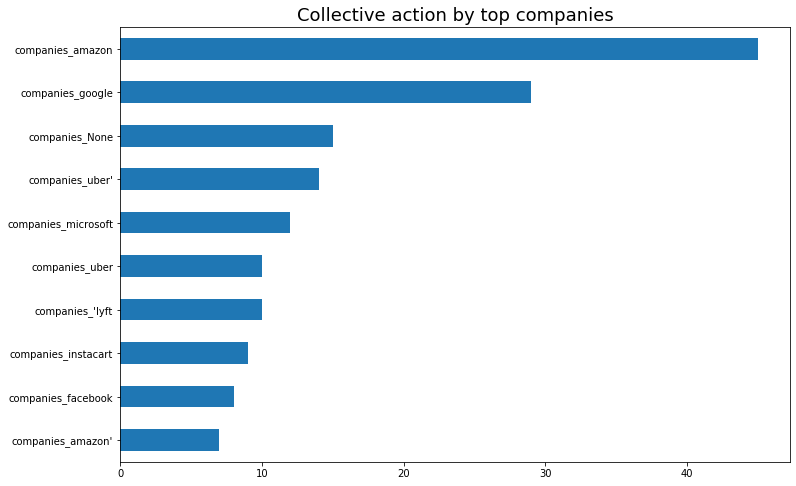

In [60]:
ax = top_10_companies_df.plot(kind="barh", figsize=(12, 8))
ax.set_title("Collective action by top companies", fontsize=18)

In [61]:
def get_top_companies(cond):
    return ohe_df[ohe_df["is_priviledged"] == cond].filter(regex=("companies_*")).sum()


top_companies = pd.DataFrame(get_top_companies(True)).join(
    pd.DataFrame(get_top_companies(False)),
    lsuffix="_priviledged_workers",
    rsuffix="_precarious_workers",
)
top_companies = (
    top_companies.assign(tmp=top_companies.sum(axis=1))
    .sort_values(by="tmp")[-10:]
    .drop("tmp", 1)
)

Text(0.5, 1.0, 'Collective action by top companies')

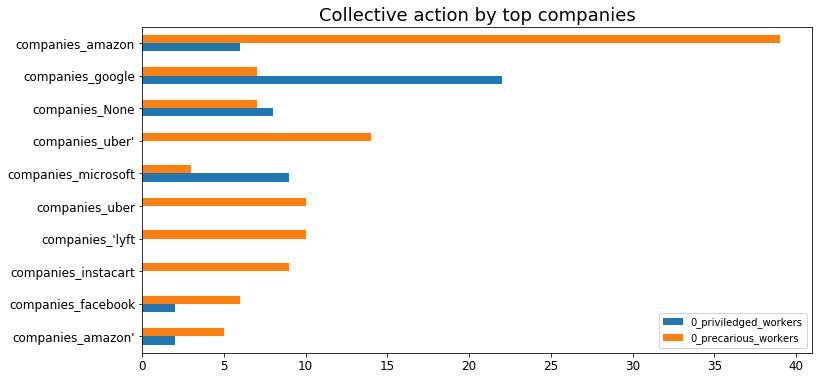

In [62]:
ax = top_companies.plot(kind="barh", fontsize=12, figsize=(12, 6))
ax.set_title("Collective action by top companies", fontsize=18)

## Using word clouds

Define some helper funcs

In [63]:
# color generator function
def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return("hsl(230,100%%,%d%%)" % np.random.randint(30,60))

# helper function to get words from df columns
def get_text(col):
    return df[col].str.cat(sep=" ").replace(",", "").replace("None", "")

# helper func to pot word cloud
def plot_cloud(text, figsize=(18,12)):
    wc_params = {
        "background_color": "white", 
        "width": figsize[0]*100, 
        "height": figsize[1]*100, 
        "collocations": False
    }
    wc = WordCloud(**wc_params).generate(text)
    wc.recolor(color_func = grey_color_func)
    plt.figure(figsize=figsize)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

Visualize descriptions

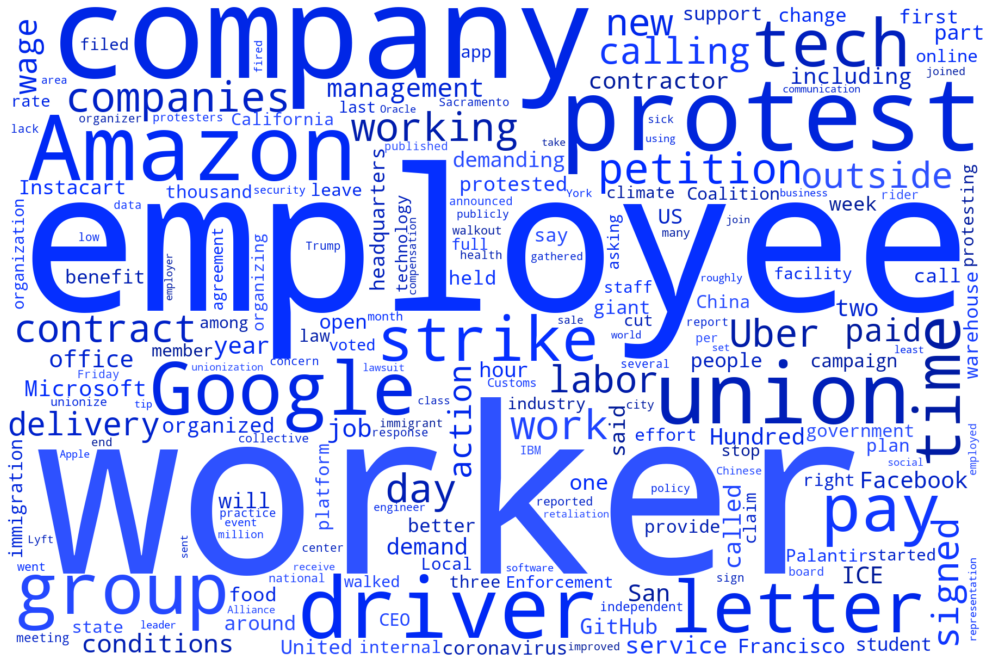

In [64]:
text = get_text('description')
plot_cloud(text)

visualize tags

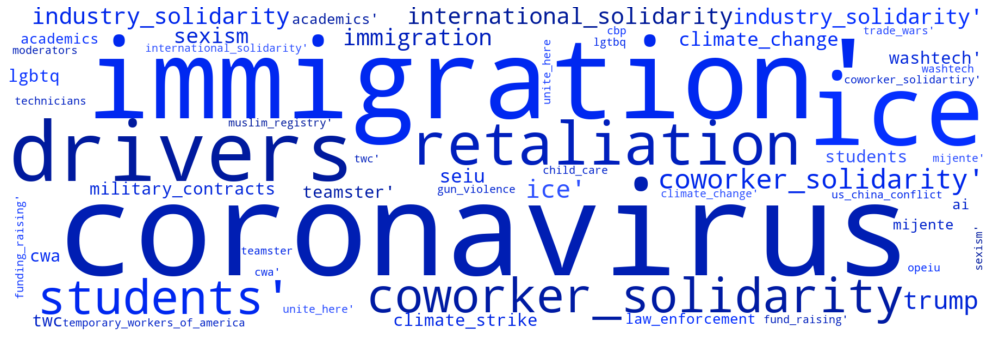

In [65]:
text = get_text('tags')
plot_cloud(text, figsize=(18, 6))

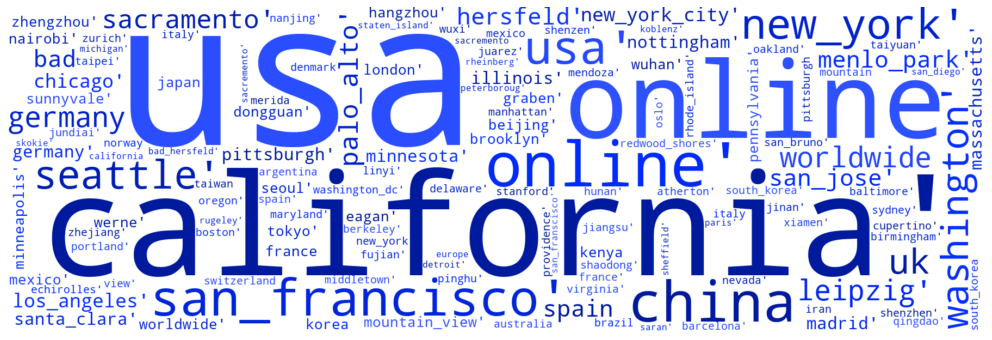

In [66]:
text = get_text('locations')
plot_cloud(text, figsize=(18, 6))